In [1]:
%matplotlib inline 

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

Import actual power spectra from Abacus c009

In [2]:
power_spectra = np.genfromtxt("CLASS_power")

Text(0, 0.5, 'P(k)')

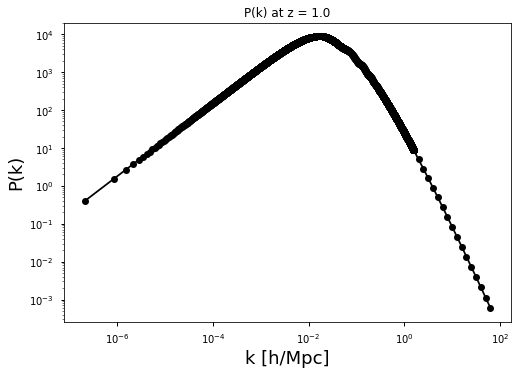

In [3]:
fs = 18
k_sims = power_spectra[:,0]
Pk_sims = power_spectra[:,1]
plt.loglog(k_sims, Pk_sims, 'ko-')
plt.title("P(k) at z = 1.0")
plt.xlabel("k [h/Mpc]", fontsize = fs)
plt.ylabel("P(k)", fontsize = fs)

Do a 1D interpolation for integration 

In [4]:
from scipy.interpolate import interp1d
Pk_interp = interp1d(k_sims, Pk_sims, kind='cubic')

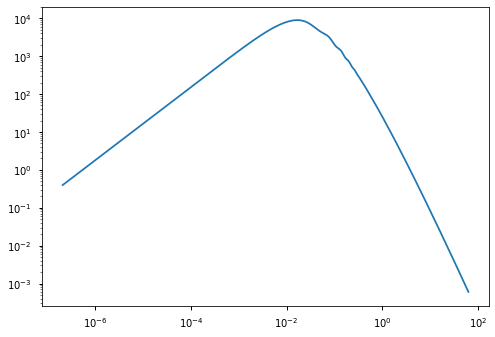

In [5]:
plt.loglog(k_sims, Pk_interp(k_sims))

Define global parameters

In [6]:
c = 299792.458 #speed of light km/s
H0 = 67.36 #km/s/Mpc
omegaM = 0.3138
omegaL = 1 - omegaM

Define comoving distance

Assuming negligible curvature and radiation density

\begin{equation}
E(z) = \sqrt{\Omega_M (1 + z)^3 + \Omega_{\Lambda}}
\end{equation}

\begin{equation}
\chi (z) = \frac{c}{H_0} \int_{0}^{z} \frac{dz'}{E(z')}
\end{equation}

In [7]:
inv_Ez = lambda z : 1./np.sqrt(omegaM*(1 + z)**3 + omegaL) #1/E(z) from Hogg
chi = lambda z : c/H0 * integrate.quad(inv_Ez, 0, z)[0] #comoving distance

In [9]:
redz_array = np.arange(0, 5, .1)
chi_array = [chi(redz_array[i]) for i in range(len(redz_array))]

Text(0, 0.5, 'comoving distance')

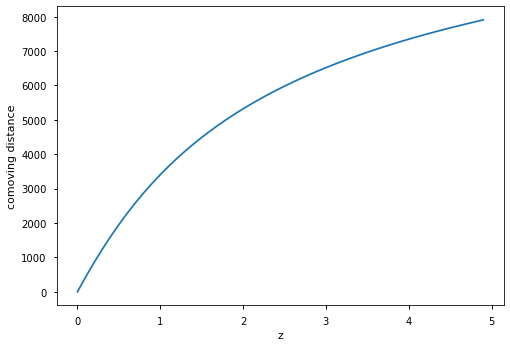

In [10]:
plt.plot(redz_array, chi_array)
plt.xlabel("z")
plt.ylabel("comoving distance")

Define lensing kernel

\begin{equation}
W^{\kappa} = \frac{3\Omega_M}{c^2} \frac{H_0}{E(z)} (1 + z) \chi(z) \frac{\chi_* - \chi}{\chi_*}
\end{equation}

In [19]:
#chistar is comoving distance to last scattering surface at z ~= 1090
zstar = 1090
chistar = chi(z = zstar)

In [12]:
Wk = lambda z : (3 * omegaM)/c**2 * H0 * inv_Ez(z) * (1 + z) * chi(z) * ((chistar - chi(z))/chistar)

In [13]:
Wk_array = [Wk(redz_array[i]) for i in range(len(redz_array))]

Text(0, 0.5, 'kappa lensing kernel')

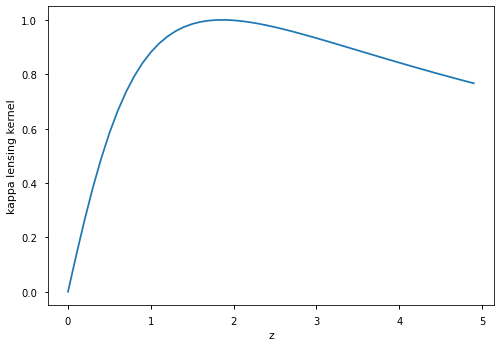

In [14]:
plt.plot(redz_array, Wk_array/np.max(Wk_array)) #normalized max to 1
plt.xlabel("z")
plt.ylabel("kappa lensing kernel")

Define $C^{\kappa \kappa}_{l}$

\begin{equation}
C^{\kappa \kappa} (l) = \frac{H_0}{c} \int_{0}^{z_{*}} dz \frac{E(z)}{\chi^2(z)} \left[ W^{\kappa} \right]^2 P \left( k = \frac{l}{\chi (z)}, z \right)
\end{equation}

In [17]:
integrand = lambda z, l : H0/c * 1/inv_Ez(z) * 1/(chi(z))**2 * (Wk(z))**2 * Pk_interp(l/chi(z)) 

In [20]:
integrate.quad(integrand, 0, zstar, args=(100))

(3.779642574216613e-17, 3.613233289790577e-17)

In [23]:
l = np.arange(100, 1000, 1)
Cl = [integrate.quad(integrand, 0, zstar, args=(val))[0] for val in l]

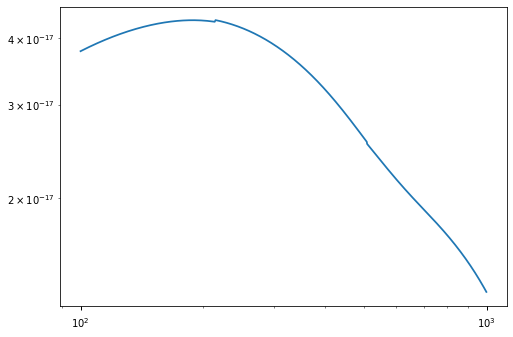

In [26]:
plt.loglog(l, Cl)

In [27]:
import pyccl as ccl

In [30]:
#define cosmology; not specified alpha_s = 0.0, N_ur = 2.0328, N_ncdm = 1.0, omega_ncdm = 0.0006442
#https://github.com/abacusorg/AbacusSummit/blob/master/Cosmologies/abacus_cosm000/CLASS.ini
cosmo = ccl.Cosmology(Omega_c = 0.26447, Omega_b = 0.04930, \
        h = 0.6736, n_s = 0.9649, A_s=2.083e-9, \
        w0 = -1.0, wa = 0.0)

In [32]:
#calculate theoretical Cls
lmax = 1024
ell = np.arange(0, lmax, 1) #lmax = 1500
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

(100, 1000)

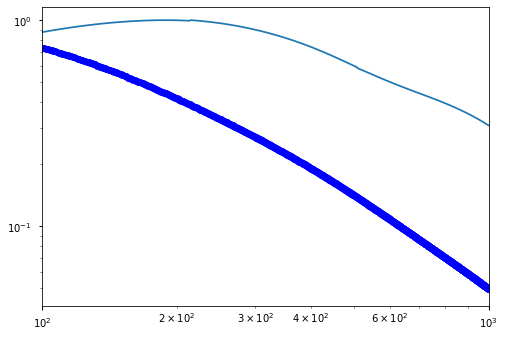

In [36]:
plt.plot(ell, cls_cmb/np.max(cls_cmb), 'bo-', label = 'CCL')
plt.plot(l, Cl/np.max(Cl))
plt.yscale('log')
plt.xscale('log')
plt.xlim([100, 1000])